# 2. Figure 2

This notebook is used to create the panels of Figure 2.

Before starting, use 1.Preprocessing notebook to generate:
- SC1_normalized.h5ad - Normalized single-cell data

Download data available at Metabolights [www.ebi.ac.uk/metabolights/MTBLS11236], study identifier MTBLS11236 and move to data folder:
- SC1_FDR.csv - FDR data downloaded from METASPACE project Delafiori  et al. (2024) [https://metaspace2020.eu/project/HTSpaceM]
- SC1_metabolite_IDs.csv - Metabolite metadata
- list_pathways - List of kegg pathways per metabolism type

In [1]:
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap 
import pandas as pd
import scanpy as sc
from anndata import read_h5ad

### Set plot style

In [2]:
%matplotlib inline
%config InlineBackend.figure_formats=['retina']
sns.set(rc={'figure.figsize':(5, 5),
            'legend.frameon':False},
        style='ticks',
        context='talk')

# Render figures with higher resolution.
plt.rcParams['figure.dpi']=200
# Save with transparent regions white background.
plt.rcParams['savefig.facecolor']='white'

### Create color palette

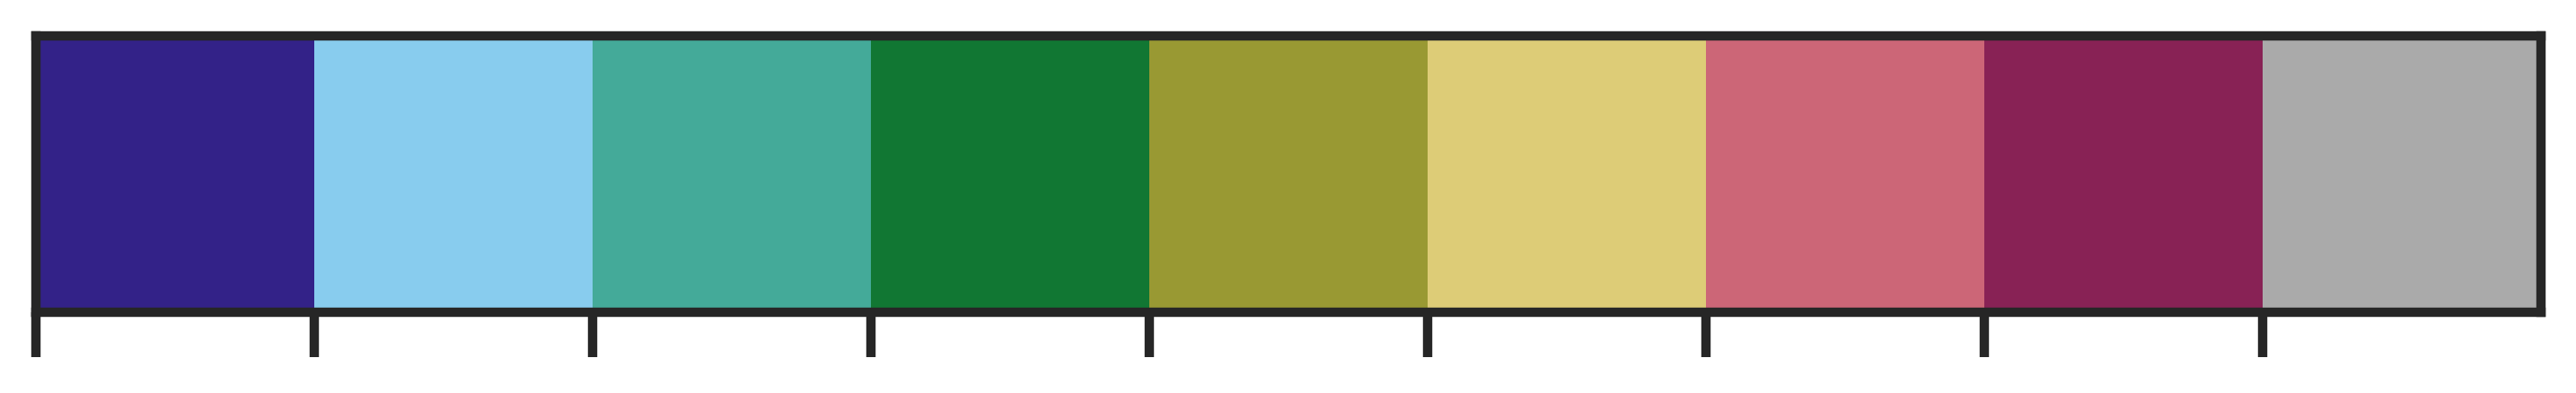

In [3]:
#color palette
palette = [(51,34,136),(136,204,238),(68,170,153),(17,119,51),(153,153,51),(221,204,119),(204,102,119),(136,34,85),(170,170,170)]
palette = [(e[0]/255.0, e[1]/255.0, e[2]/255.0) for e in palette]
cmap = ListedColormap(palette)
sns.color_palette(palette=None,as_cmap=True)
sns.palplot(palette)

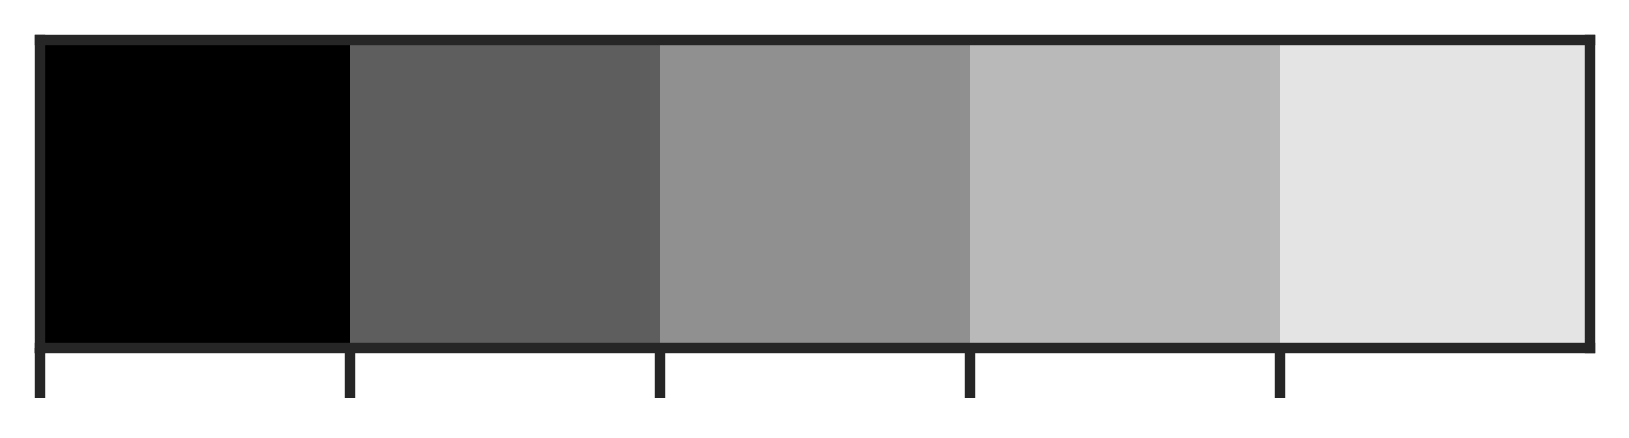

In [4]:
#color palette2
palette2 = [(0,0,0),(94,94,94),(144,144,144),(185,185,185),(228,228,228)]
palette2 = [(e[0]/255.0, e[1]/255.0, e[2]/255.0) for e in palette2]
cmap = ListedColormap(palette2)
sns.color_palette(palette=None,as_cmap=True)
sns.palplot(palette2)

## Panel A
HeLa microscopy cells with a representation of cell segmentation, ablation marks and single-cell ion intensities.

## Panel B

### Set paths

In [5]:
#input
data_dir = Path(r'../data')
FDR_path = data_dir / 'SC1_FDR.csv'

#output
plots_path =  Path(r'../') / 'figures' / 'figure_2'
plots_path.mkdir(parents=True, exist_ok=True)
sc.settings.figdir = plots_path

### Load data

In [6]:
# FDR values downloaded from METASPACE project 'Delafiori et al. (2024)'
FDR = pd.read_csv(FDR_path)
FDR = FDR.astype(str).groupby(['datasetKey', 'CellLine', 'fdr'])['fdr'].count().unstack().fillna(0).astype(int)
FDR.columns.name = None

#ccomputing cumulative FDR
FDR['0.1'] = FDR['0.05'] + FDR['0.1']
FDR['0.2'] = FDR['0.1'] + FDR['0.2']
FDR['0.5'] = FDR['0.2'] + FDR['0.5']

### Histogran and boxplot

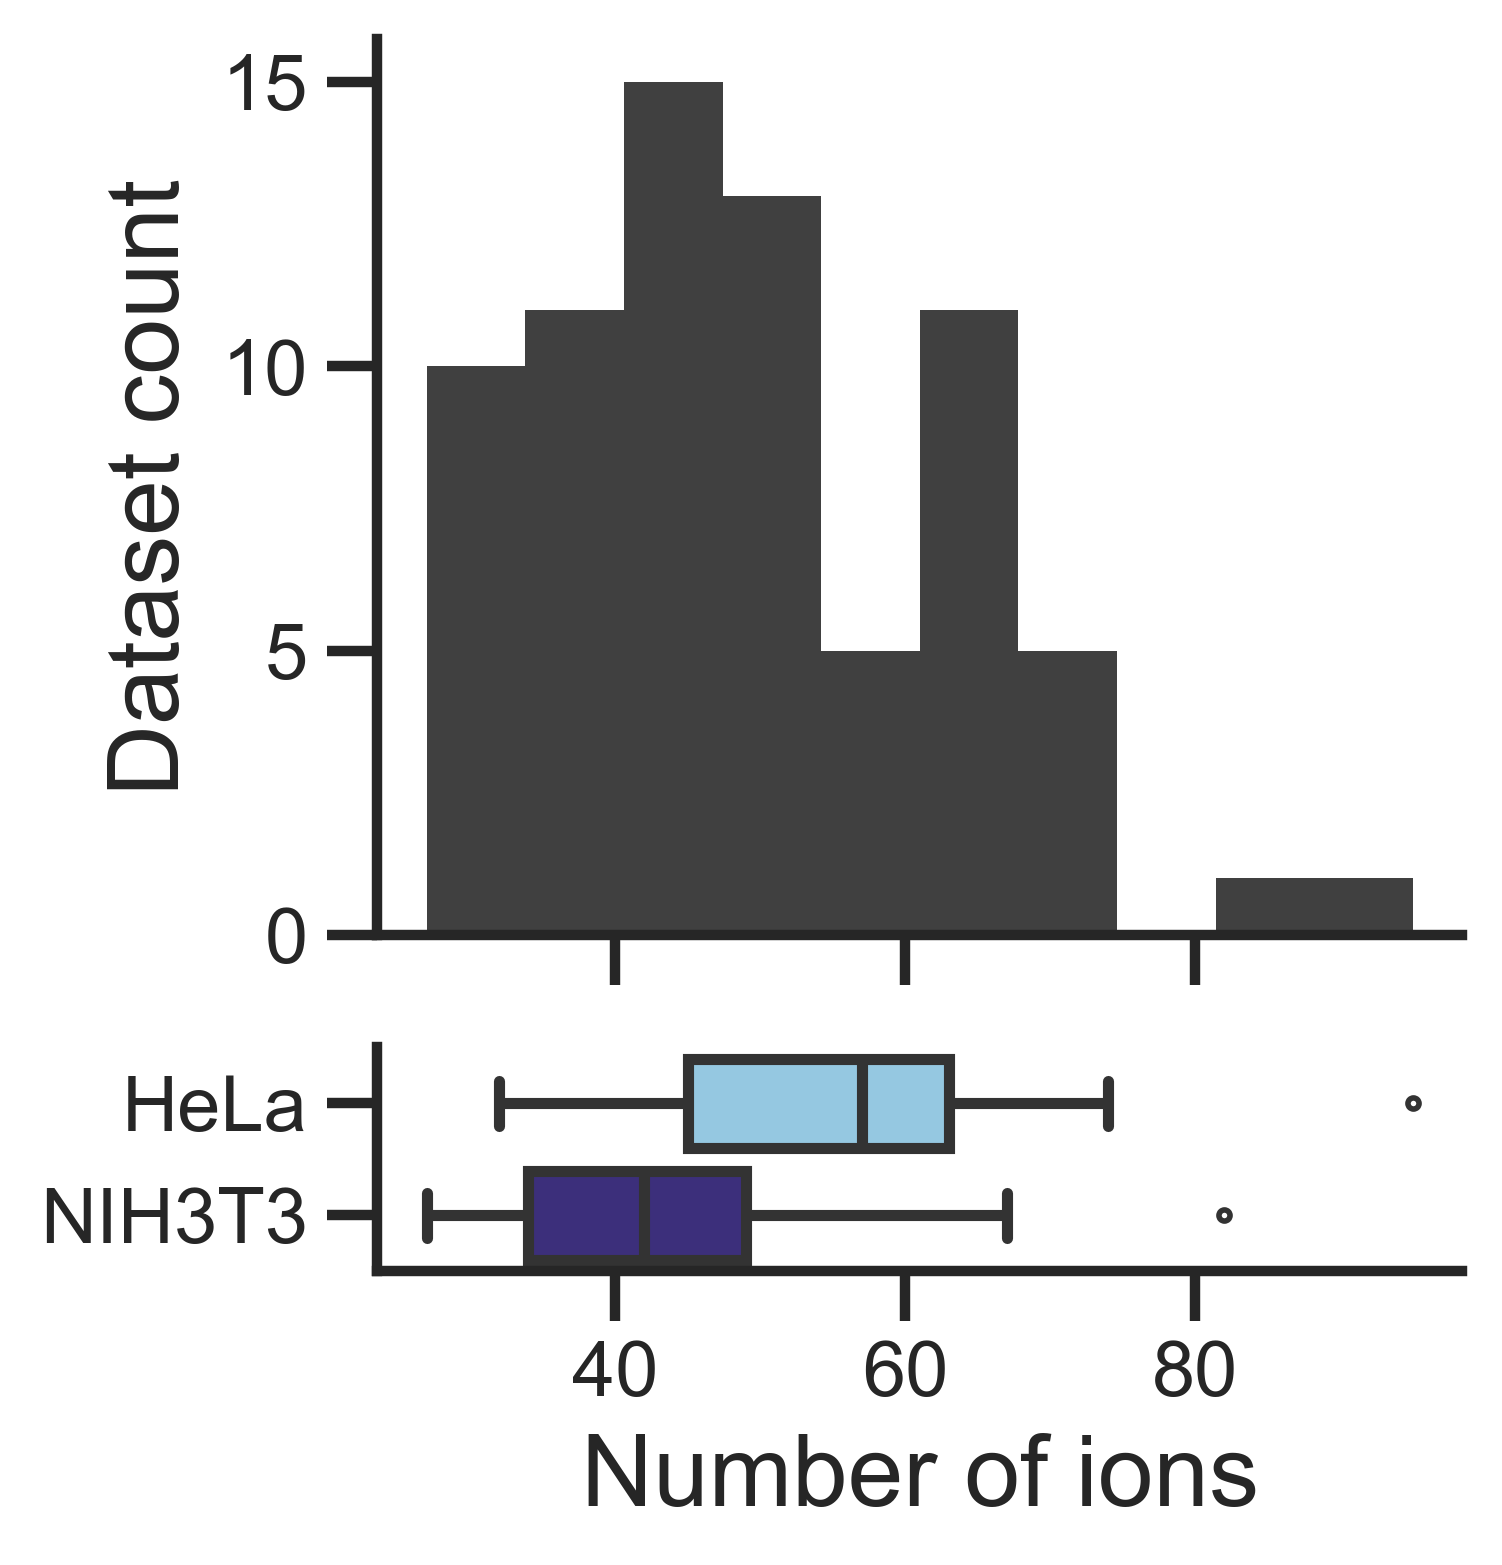

In [7]:
f = plt.figure(figsize=(3.5, 4))
# Defining a gridspec where the subplots are placed
gs = f.add_gridspec(2, 1, height_ratios=(4,1))
ax_down = f.add_subplot(gs[1, 0])
ax_main = f.add_subplot(gs[0, 0], sharex=ax_down)

sns.histplot(data=FDR, 
            x='0.1', 
            bins=10, 
            linewidth=0, 
            color='Black',
            legend=False,
            ax=ax_main)

sns.boxplot(data=FDR, 
            x='0.1', 
            y='CellLine', 
            palette=palette[0:2],
            fliersize=2,
            hue='CellLine',
            linewidth=2,
            hue_order=['NIH3T3','HeLa'],
            orient='h',
            legend=False,
            ax=ax_down)

plt.setp(ax_main.get_xticklabels(), visible=False)
plt.setp(ax_down.get_xticklabels(minor=True), visible=True)
sns.despine(offset=0, trim=False, ax=ax_down)
sns.despine(trim=False, ax=ax_main)
ax_main.set_ylabel('Dataset count', fontsize=18)
ax_main.tick_params('both', labelsize=14)
ax_main.set_xlabel(' ')
ax_down.tick_params('both', labelsize=14)
ax_down.set_ylabel('')
ax_down.set_xlabel(u'Number of ions', fontsize=18)

plt.savefig(plots_path / 'panel_B.png', bbox_inches='tight')
plt.savefig(plots_path / 'panel_B.svg', bbox_inches='tight')

## Panel C

### Set paths

In [8]:
#input
data_dir = Path(r'../data')
anndata_path = data_dir / 'SC1_normalized.h5ad'

#output
plots_path =  Path(r'../') / 'figures' / 'figure_2'
plots_path.mkdir(parents=True, exist_ok=True)
sc.settings.figdir = plots_path

### Load anndata

In [9]:
#load anndata file
adata =  sc.read_h5ad(anndata_path)
adata.raw = adata

In [10]:
cell_qc, ion_qc = sc.pp.calculate_qc_metrics(adata, percent_top=[135])
# the condition column should be in adata.obs
condition_column = 'CellLine'
# qc table and adata.obs should have the same index
cell_qc_joined = pd.merge(adata.obs[[condition_column]], cell_qc, left_index=True, right_index=True)

### Histogram

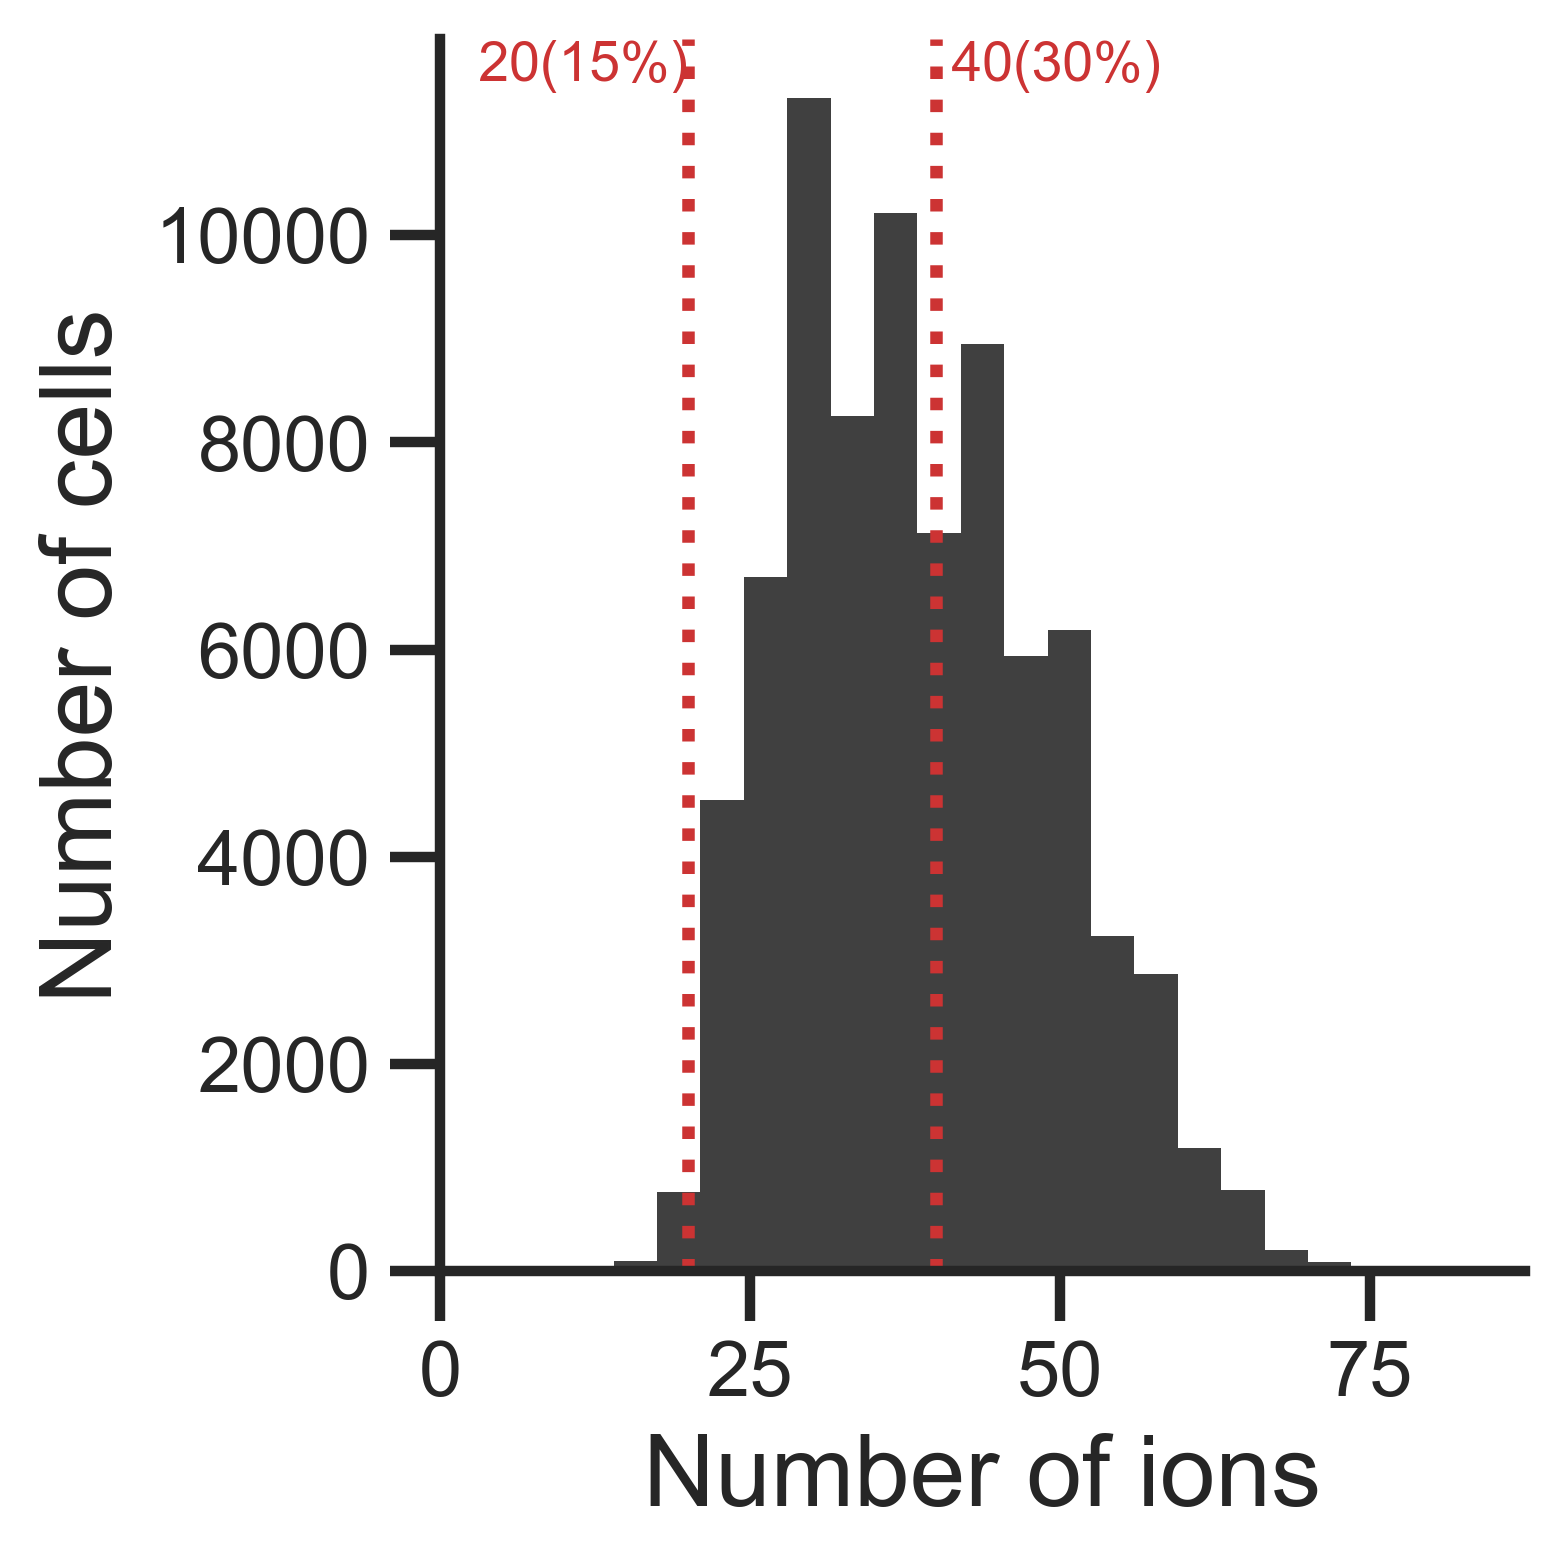

In [11]:
# calculate the cutoff percentage of ions present in each cell
min_ions1 = 20
min_ions2 = 40
percent_ions1 = min_ions1 / len(adata.var_names)
percent_ions2 = min_ions2 / len(adata.var_names)

plt.figure(figsize=(3.5, 4))
ax = sns.histplot(data=cell_qc_joined, 
                  x='n_genes_by_counts', 
                  bins=20, 
                  linewidth=0,
                  color='black',
                  multiple='stack')

ax.set_xlabel('Number of ions', fontsize=18)
ax.set_ylabel('Number of cells', fontsize=18)
ax.tick_params(axis='both', labelsize=14)
ax.set_xlim(left=0)
sns.despine(offset=0, trim=False, ax=ax)
sns.despine(trim=False, ax=ax)

# printing the cutoff as a vertical line with relative and absolute cutoff values
ax.axvline(x=min_ions1, linestyle=':', c='#CC3333')
ax.text(x=min_ions1, y=ax.get_ylim()[1], s=f' {min_ions1}({percent_ions1:.0%})', 
        fontsize=10, va='top', ha='right', color='#CC3333')
ax.axvline(x=min_ions2, linestyle=':', c='#CC3333')
ax.text(x=min_ions2, y=ax.get_ylim()[1], s=f' {min_ions2}({percent_ions2:.0%})', 
        fontsize = 10, va='top', ha='left', color='#CC3333')

plt.savefig(plots_path / 'panel_C.png', bbox_inches='tight')
plt.savefig(plots_path / 'panel_C.svg', bbox_inches='tight')

## Panel D
Metabolic pathways highlighting metabolites detected in the single-cell analysis colored by metabolite class.
Graph generated with iPath3 (https://pathways.embl.de/ipath3.cgi?map=metabolic) using Kegg IDs

## Panel E

### Set paths

In [12]:
#input
data_dir = Path(r'../data')
metabolite_path = data_dir / 'SC1_metabolite_IDs.csv'

#output
plots_path =  Path(r'../') / 'figures' / 'figure_2'
plots_path.mkdir(parents=True, exist_ok=True)
sc.settings.figdir = plots_path

### Load data

In [13]:
metabolite_class = pd.read_csv(metabolite_path)

In [14]:
subclass_order = ['Amino acids derivatives',
                  'Amino acids',
                  'Dipeptides',
                  'N-acyl amino acids',
                  'Lipids and lipid-like molecules',
                  'Carbohydrates and carbohydrate conjugates',
                  'Nucleosides, nucleotides, and analogs',
                  'Hydroxy acids, keto acids, carboxylic acids, and derivatives',
                  'Purines, pyrimidines, and derivatives',
                  'Inorganic phosphates, organic phosphates, and derivatives',
                  'Vitamins and cofactors',
                  'Others']

In [15]:
#Filtering for metabolites present in both single-cell (SC) and LC-MS/MS (Bulk) data
SC_subclass = metabolite_class[(metabolite_class['detection']=='SC-Bulkneg-Bulkpos')|
                               (metabolite_class['detection']=='SC-Bulkneg')|
                               (metabolite_class['detection']=='SC-Bulkpos')|
                               (metabolite_class['detection']=='SC')]
subclass = SC_subclass.groupby(['subclass', 'class'])['subclass'].count()
subclass = subclass.to_frame(name ='SC').reset_index().rename(columns={'index':'subclass'})
                                                                                            
# Convert the column to categorical with the specific order
subclass['subclass'] = pd.Categorical(subclass['subclass'], categories=subclass_order, ordered=True)

# Sort the DataFrame based on the categorical order
dic = {'SC':int}
subclass = subclass.sort_values(by='subclass').reindex().astype(dic)

### Barplot

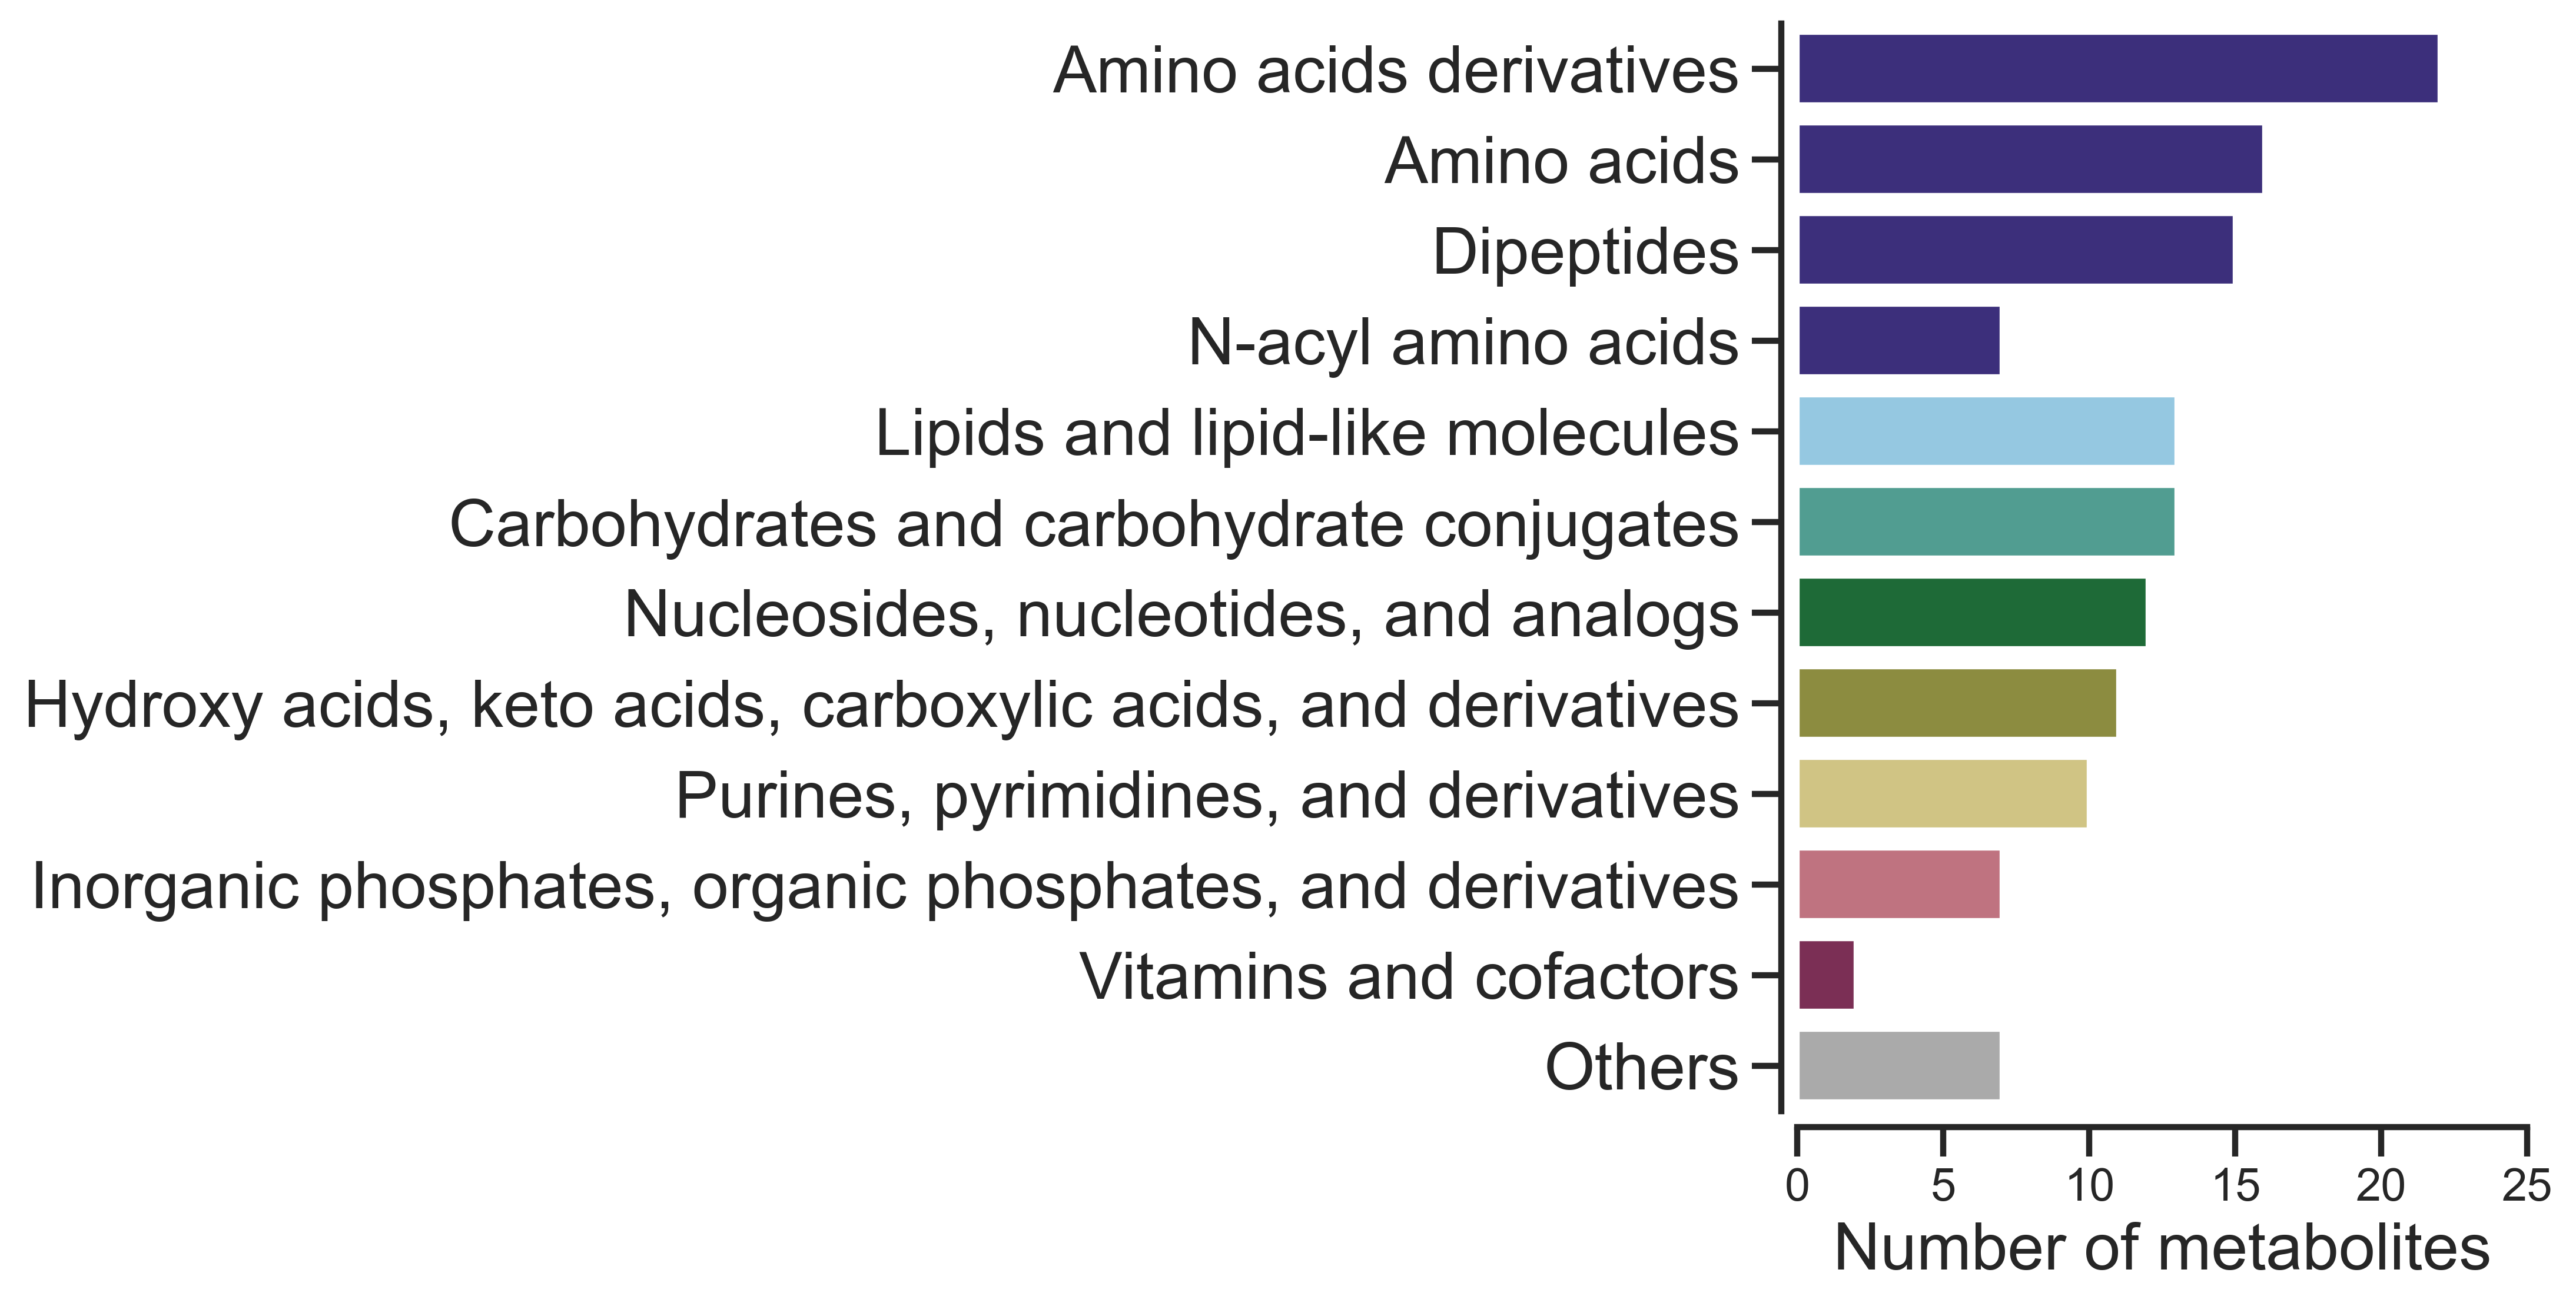

In [16]:
plt.figure(figsize=(4, 6))
ax = sns.barplot(data=subclass,
                 x='SC',
                 y='subclass',
                 orient='h',
                 hue='class',
                 palette = palette,
                 legend=False)

sns.despine(offset=5,trim=False,  ax=ax)
ax.set_xlabel('Number of metabolites', fontsize=20)
ax.set_ylabel('')
plt.yticks(fontsize=20)
plt.xticks(ticks=[0,5,10,15,20,25], fontsize=14)

plt.savefig(plots_path / 'panel_E.png', bbox_inches='tight')
plt.savefig(plots_path / 'panel_E.svg', bbox_inches='tight')

## Panel F

### Set paths

In [17]:
#input
data_dir = Path(r'../data')
metabolite_path = data_dir / 'SC1_metabolite_IDs.csv'
pathways_path = data_dir / 'list_pathways.csv'

#output
plots_path =  Path(r'../') / 'figures' / 'figure_2'
plots_path.mkdir(parents=True, exist_ok=True)
sc.settings.figdir = plots_path

### Load data

In [18]:
metabolite_pathways = pd.read_csv(metabolite_path)
#classification of pathways to main metabolism classes
pathways_list = pd.read_csv(pathways_path)

In [19]:
#counting the number of kegg pathways listed for the single-cell  metabolites
metabolite_pathways = metabolite_pathways['kegg_pathway'].replace(';', '";"').str.split(';').explode('kegg_pathway').value_counts()
metabolite_pathways = metabolite_pathways.to_frame(name = 'value').reset_index()

In [20]:
#ordering the most relevant pathways per metabolism class
pathways_class = metabolite_pathways.merge(pathways_list, on='kegg_pathway', how='outer')
pathways_class = pathways_class.sort_values(['metabolism', 'value'], ascending=[True, False])
pathways_class = pathways_class.sort_values(['metabolism', 'value'], ascending=[True, False])

###  Barplot

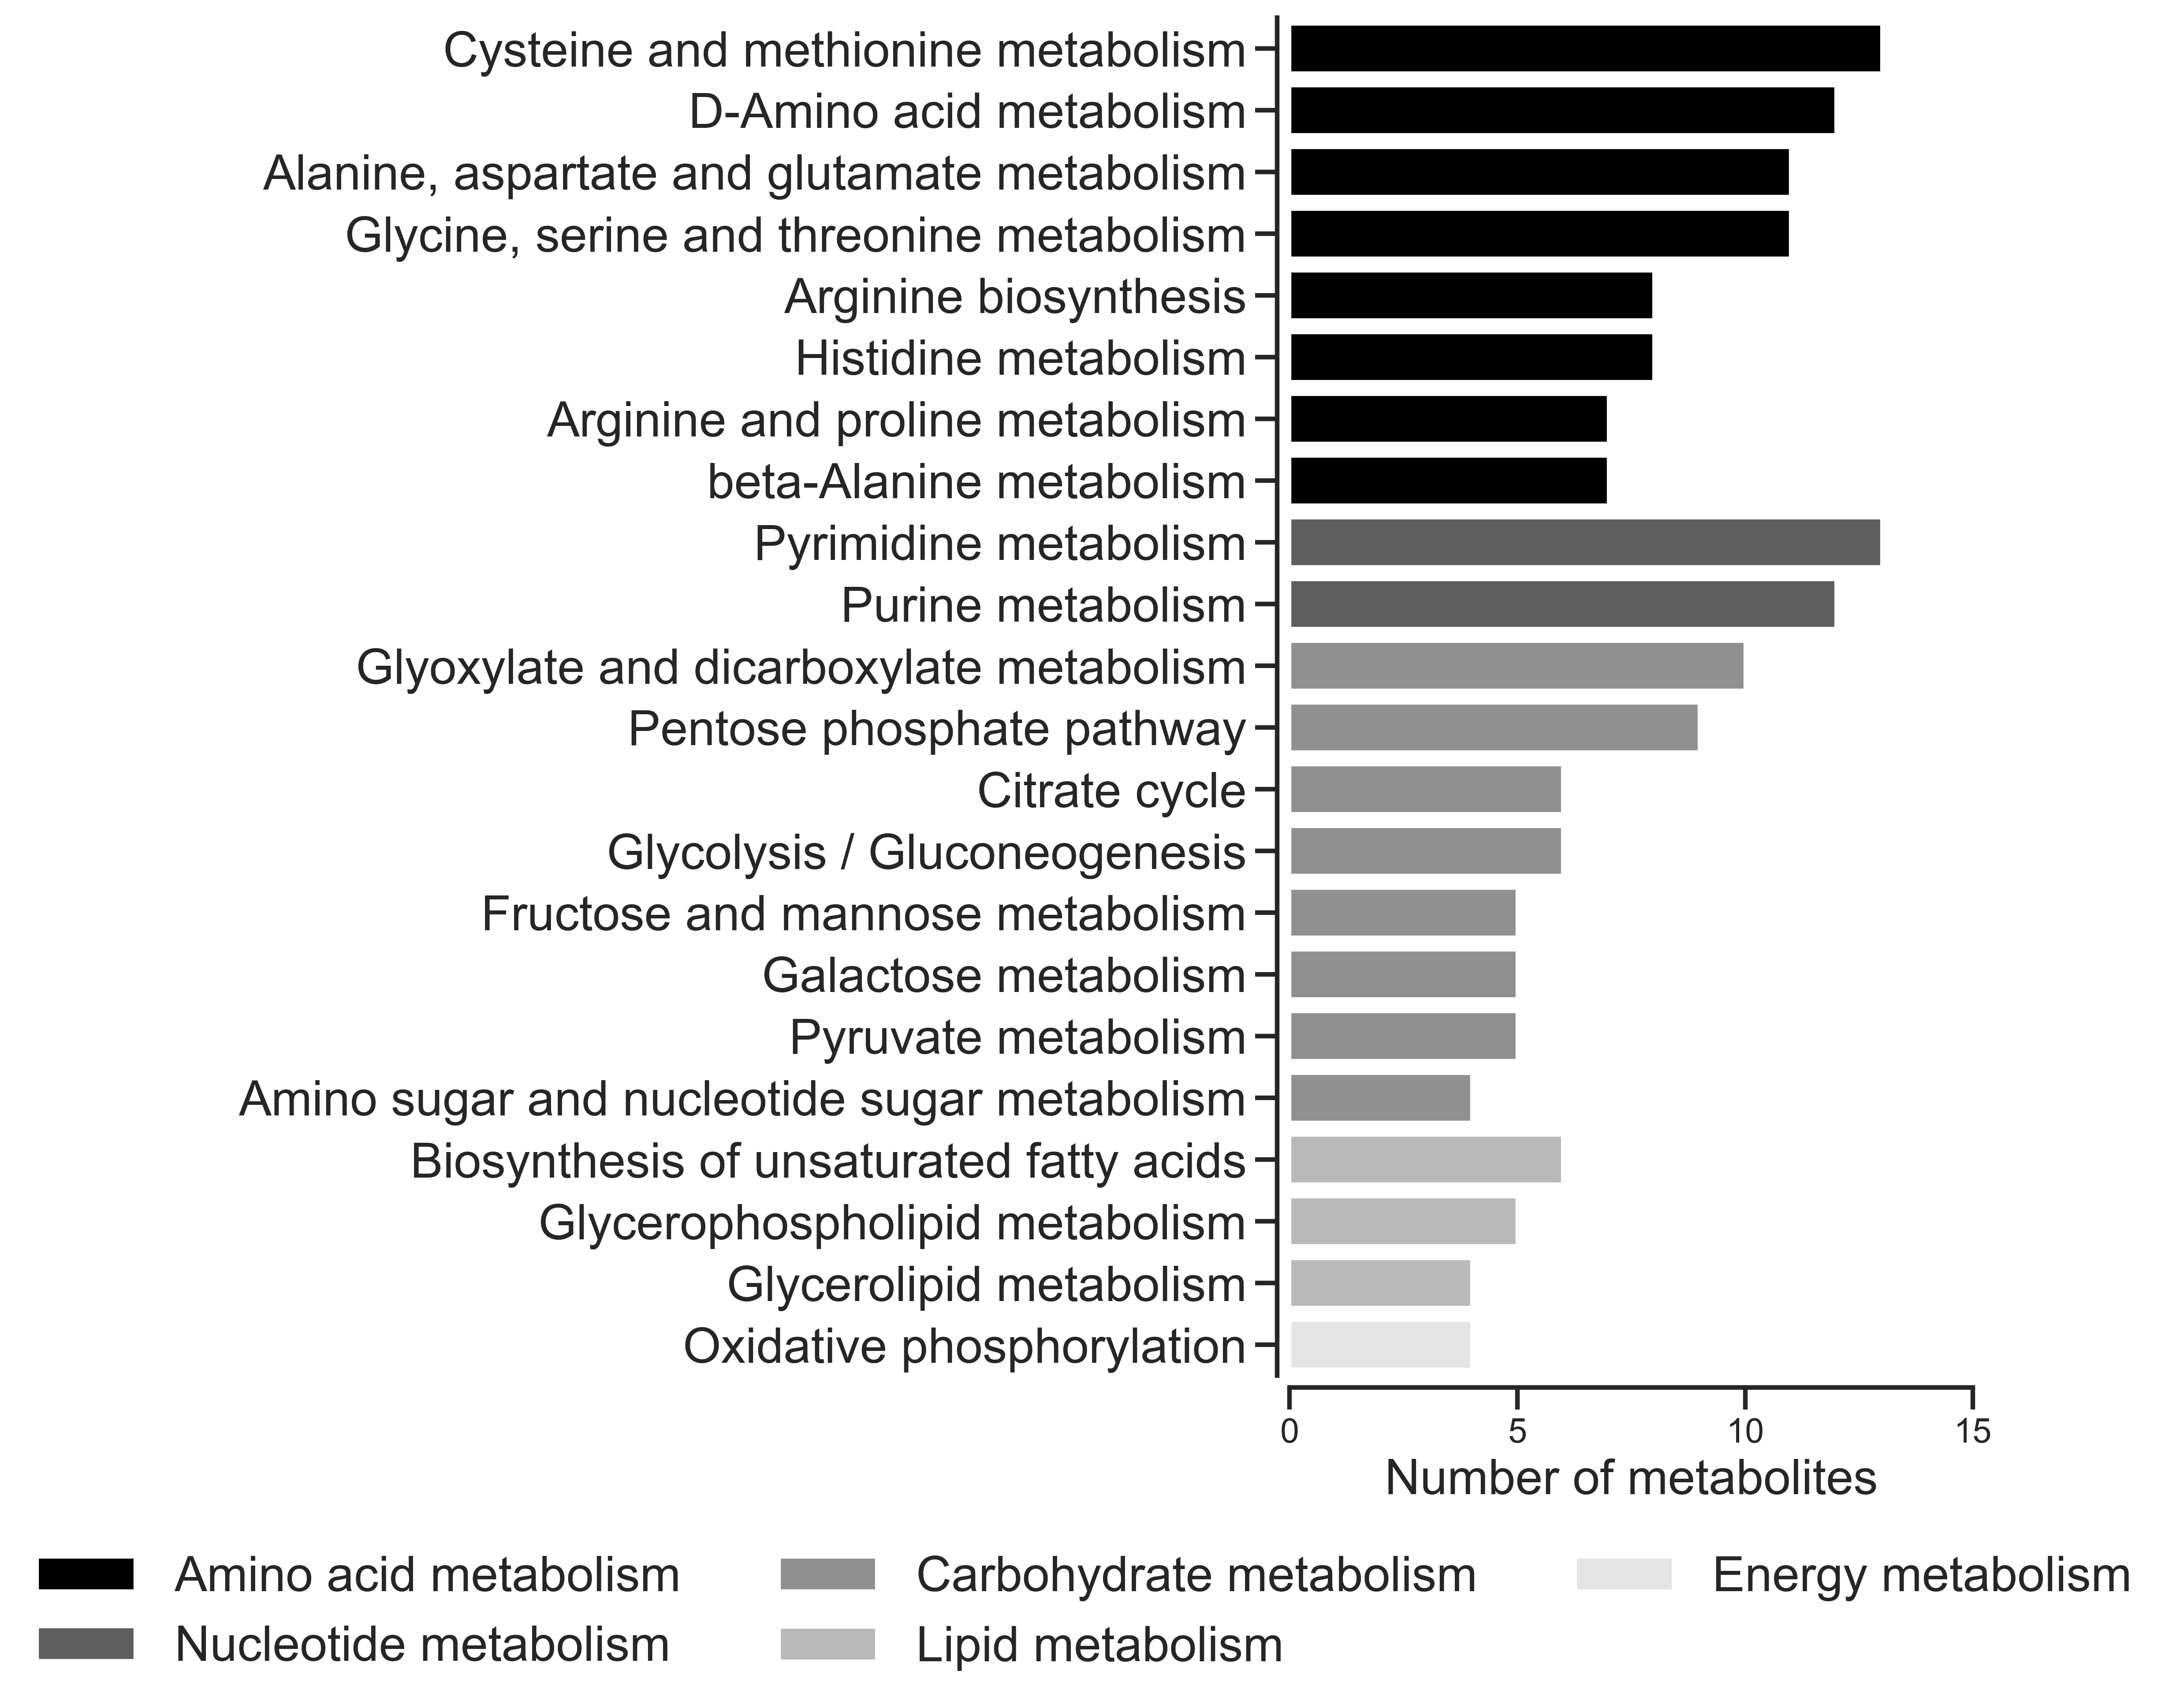

In [21]:
#filtering the most relevant pathways per metabolism class
pathclass_filter = {'Amino acid metabolism': 8,
                    'Nucleotide metabolism': 2,
                    'Carbohydrate metabolism': 8,
                    'Lipid metabolism': 3,
                    'Energy metabolism': 1}

barplot_data = pd.DataFrame(columns=pathways_class.columns)
for metabolism, rows in pathclass_filter.items():
    df = pathways_class[pathways_class['metabolism']==metabolism].head(rows)
    barplot_data = pd.concat([barplot_data, df])

plt.figure(figsize=(5, 10))
ax = sns.barplot(data=barplot_data,
                 x='value',
                 y='kegg_pathway',
                 orient='h',
                 hue='metabolism',
                 palette=palette2,
                 legend=True)

sns.despine(offset=5,trim=False, ax=ax)
ax.legend(loc='lower center', bbox_to_anchor=(-0.3,-0.25), ncols=3, fontsize=20, markerscale=0.5)
ax.set_ylabel("")
ax.set_xlabel("Number of metabolites", fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(ticks=[0,5,10,15], fontsize=14)

plt.savefig(plots_path / 'panel_F.png', bbox_inches='tight')
plt.savefig(plots_path / 'panel_F.svg', bbox_inches='tight')

## Panel G
Venn diagram created using Inkscape with the column 'detection' of the 'SC1_metabolite_IDs.csv' file